# KNN Implementation on scaled reduced dataset with LDA

In [16]:
# Utilities
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, accuracy_score, f1_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [9]:
seed = 23

In [10]:
df_scaled = pd.read_csv('../../Data/dataset_preprocessed.csv')

In [11]:
df_lda = pd.read_csv('../../DimensionalityReductionData/lda.csv')

In [12]:
df_scaled = df_scaled[['averageRating']]
df_scaled['LD1'] = df_lda['LD1']

<ipython-input-12-529454da6465>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scaled['LD1'] = df_lda['LD1']


In [13]:
df_scaled_sample = df_scaled

In [14]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1),
    df_scaled_sample['averageRating'], test_size=test_size,
    random_state=seed
)

In [15]:
def calculate_metrics(model_name, y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Weighted F1': f1_score(y_true, y_pred, average='weighted'),
        'Weighted Precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'Weighted Recall': recall_score(y_true, y_pred, average='weighted'),
        'Macro-Averaged Precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'Macro-Averaged Recall': recall_score(y_true, y_pred, average='macro'),
        'F1': str(f1_score(y_true, y_pred, average=None)),
        'Precision': str( precision_score(y_true, y_pred, average=None, zero_division=0)),
    }

    # Print the metrics
    print(f"Metrics for {model_name}:")
    for metric_name, metric_value in metrics.items():
        try:
            print(f"{metric_name}: {metric_value:.4f}")
        except:
            print(f"{metric_name}: {metric_value}")

    # Print the classification report
    print("classification report")
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'], zero_division=0)
    print(report)

    print("Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
    cmd.plot()

    plt.title(f'Confusion matrix for model {model_name} (Accuracy:{metrics["Accuracy"]:.4f})')
    plt.show()

    # Create df to store metrics
    df_metrics = pd.DataFrame(metrics, index=[model_name])

    return df_metrics

In [17]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))

print("F1 score:", f1_score(y_test, predictions, average=None))

Accuracy: 0.5892738174550299
F1 score: [0.59928502 0.57874957]


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

param_grid = {
    'n_neighbors': [3, 7, 15],
    'p': [1, 2, 3, 4.3],
    'n_jobs': [-1, 1]
}

model = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("The parameters with the highest score: ", grid_search.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
The parameters with the highest score:  {'n_jobs': -1, 'n_neighbors': 15, 'p': 1}


In [19]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# Show top 10 parameters for this model
minimalistic_results = cv_results_df[['params', 'mean_test_score']]
sorted_results = minimalistic_results.sort_values(by='mean_test_score', ascending=False)

print(sorted_results.head(10))

                                         params  mean_test_score
23   {'n_jobs': 1, 'n_neighbors': 15, 'p': 4.3}         0.621460
22     {'n_jobs': 1, 'n_neighbors': 15, 'p': 3}         0.621460
21     {'n_jobs': 1, 'n_neighbors': 15, 'p': 2}         0.621460
8     {'n_jobs': -1, 'n_neighbors': 15, 'p': 1}         0.621460
9     {'n_jobs': -1, 'n_neighbors': 15, 'p': 2}         0.621460
10    {'n_jobs': -1, 'n_neighbors': 15, 'p': 3}         0.621460
11  {'n_jobs': -1, 'n_neighbors': 15, 'p': 4.3}         0.621460
20     {'n_jobs': 1, 'n_neighbors': 15, 'p': 1}         0.621460
16      {'n_jobs': 1, 'n_neighbors': 7, 'p': 1}         0.609797
4      {'n_jobs': -1, 'n_neighbors': 7, 'p': 1}         0.609797


Metrics for KNN-LDA-GS-CV1:
Accuracy: 0.6336
Weighted F1: 0.6337
Weighted Precision: 0.6338
Weighted Recall: 0.6336
Macro-Averaged Precision: 0.6330
Macro-Averaged Recall: 0.6331
F1: [0.64720975 0.61884962]
Precision: [0.65138799 0.6145905 ]
classification report
              precision    recall  f1-score   support

     Class 0       0.65      0.64      0.65      1569
     Class 1       0.61      0.62      0.62      1433

    accuracy                           0.63      3002
   macro avg       0.63      0.63      0.63      3002
weighted avg       0.63      0.63      0.63      3002

Confusion Matrix


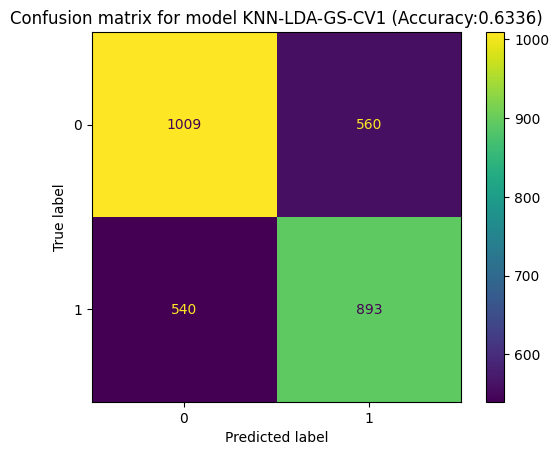

In [20]:
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
_ = calculate_metrics('KNN-LDA-GS-CV1', y_test, predictions)

In [22]:
# Predicting using other alternatives of fine-tuning from top 10 performances
other_alternatives = []
# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = KNeighborsClassifier(**params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)

  chosen_accuracy = accuracy_score(y_test, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)
  other_alternatives.append((chosen_accuracy,params))

Parameters from place:  0   {'n_jobs': 1, 'n_neighbors': 15, 'p': 4.3}
Accuracy for chosen parameters: 0.6335776149233844
Parameters from place:  1   {'n_jobs': 1, 'n_neighbors': 15, 'p': 3}
Accuracy for chosen parameters: 0.6335776149233844
Parameters from place:  2   {'n_jobs': 1, 'n_neighbors': 15, 'p': 2}
Accuracy for chosen parameters: 0.6335776149233844
Parameters from place:  3   {'n_jobs': -1, 'n_neighbors': 15, 'p': 1}
Accuracy for chosen parameters: 0.6335776149233844
Parameters from place:  4   {'n_jobs': -1, 'n_neighbors': 15, 'p': 2}
Accuracy for chosen parameters: 0.6335776149233844
Parameters from place:  5   {'n_jobs': -1, 'n_neighbors': 15, 'p': 3}
Accuracy for chosen parameters: 0.6335776149233844
Parameters from place:  6   {'n_jobs': -1, 'n_neighbors': 15, 'p': 4.3}
Accuracy for chosen parameters: 0.6335776149233844
Parameters from place:  7   {'n_jobs': 1, 'n_neighbors': 15, 'p': 1}
Accuracy for chosen parameters: 0.6335776149233844
Parameters from place:  8   {'n_

In [23]:
# get best from top 10
best_tuple = max(other_alternatives, key=lambda x: x[0])

In [24]:
print("Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances")
print(best_tuple[0])
print(best_tuple[1])

Best accuracy and parameters after running the algorithm using other alternatives of fine tuning from top 10 performances
0.6335776149233844
{'n_jobs': 1, 'n_neighbors': 15, 'p': 4.3}


In [26]:
# Run on training sample

# Choose a set of parameters from sorted_results
for i in range(10):

  params = sorted_results.iloc[i]['params']
  print("Parameters from place: ", i, " ", params)

  model = KNeighborsClassifier(**params)
  model.fit(X_train, y_train)

  predictions = model.predict(X_train)

  chosen_accuracy = accuracy_score(y_train, predictions)
  print("Accuracy for chosen parameters:", chosen_accuracy)

Parameters from place:  0   {'n_jobs': 1, 'n_neighbors': 15, 'p': 4.3}
Accuracy for chosen parameters: 0.6808563812062646
Parameters from place:  1   {'n_jobs': 1, 'n_neighbors': 15, 'p': 3}
Accuracy for chosen parameters: 0.6808563812062646
Parameters from place:  2   {'n_jobs': 1, 'n_neighbors': 15, 'p': 2}
Accuracy for chosen parameters: 0.6808563812062646
Parameters from place:  3   {'n_jobs': -1, 'n_neighbors': 15, 'p': 1}
Accuracy for chosen parameters: 0.6808563812062646
Parameters from place:  4   {'n_jobs': -1, 'n_neighbors': 15, 'p': 2}
Accuracy for chosen parameters: 0.6808563812062646
Parameters from place:  5   {'n_jobs': -1, 'n_neighbors': 15, 'p': 3}
Accuracy for chosen parameters: 0.6808563812062646
Parameters from place:  6   {'n_jobs': -1, 'n_neighbors': 15, 'p': 4.3}
Accuracy for chosen parameters: 0.6808563812062646
Parameters from place:  7   {'n_jobs': 1, 'n_neighbors': 15, 'p': 1}
Accuracy for chosen parameters: 0.6808563812062646
Parameters from place:  8   {'n_

In [29]:
best_accuracy = 0
best_report = None
best_predictions = None
y_best_predictions = None
all_reports = []

for i in range(100):
  random_state_fit = np.random.randint(1000)

  test_size = 0.2
  X_train, X_test, y_train, y_test = train_test_split(
    df_scaled_sample.drop('averageRating', axis=1),
    df_scaled_sample['averageRating'], test_size=test_size,
    random_state=random_state_fit)


  model = KNeighborsClassifier(**best_tuple[1])
  model.fit(X_train, y_train)

  predictions = model.predict(X_test)
  current_accuracy = accuracy_score(y_test, predictions)

  report = classification_report(y_test, predictions, output_dict=True, zero_division=0)
  all_reports.append(report)
  print(current_accuracy)

  if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        best_report = report
        best_predictions = predictions
        y_best_predictions = y_test

def average_classification_report(reports):
    metrics = ['precision', 'recall', 'f1-score']
    avg_report = {}
    for metric in metrics:
        avg_report[metric] = sum(r['macro avg'][metric] for r in reports) / len(reports)
    avg_report['accuracy'] = sum(r['accuracy'] for r in reports) / len(reports)
    return avg_report

avg_report = average_classification_report(all_reports)

print("Best Classification Report:")
print(classification_report(y_best_predictions, best_predictions, zero_division=0))
print("Best Accuracy:", best_accuracy)
print()
print("Average Classification Report:")
for metric, score in avg_report.items():
    print(f"{metric}: {score:.4f}")

0.6459027315123251
0.6352431712191872
0.6259160559626915
0.6325782811459028
0.6445702864756829
0.6262491672218521
0.6222518321119254
0.6235842771485676
0.6342438374417055
0.6269153897401732
0.6395736175882745
0.6182544970019986
0.6222518321119254
0.6329113924050633
0.6375749500333111
0.6335776149233844
0.6279147235176549
0.6242504996668887
0.6319120586275816
0.6269153897401732
0.6352431712191872
0.6345769487008661
0.6302465023317788
0.6415722851432378
0.6395736175882745
0.6279147235176549
0.6412391738840773
0.6149233844103931
0.6382411725516323
0.6215856095936043
0.6265822784810127
0.6372418387741505
0.6302465023317788
0.6215856095936043
0.6385742838107928
0.6249167221852099
0.6269153897401732
0.6232511658894071
0.6439040639573618
0.6245836109260493
0.6235842771485676
0.6345769487008661
0.6322451698867422
0.6345769487008661
0.6322451698867422
0.6322451698867422
0.6189207195203198
0.6192538307794804
0.6392405063291139
0.6225849433710859
0.6262491672218521
0.6359093937375083
0.6175882744

Metrics for KNN-LDA-Shuffled_best:
Accuracy: 0.6532
Weighted F1: 0.6531
Weighted Precision: 0.6533
Weighted Recall: 0.6532
Macro-Averaged Precision: 0.6533
Macro-Averaged Recall: 0.6530
F1: [0.66234187 0.6436152 ]
Precision: [0.65114796 0.65550907]
classification report
              precision    recall  f1-score   support

     Class 0       0.65      0.67      0.66      1515
     Class 1       0.66      0.63      0.64      1487

    accuracy                           0.65      3002
   macro avg       0.65      0.65      0.65      3002
weighted avg       0.65      0.65      0.65      3002

Confusion Matrix


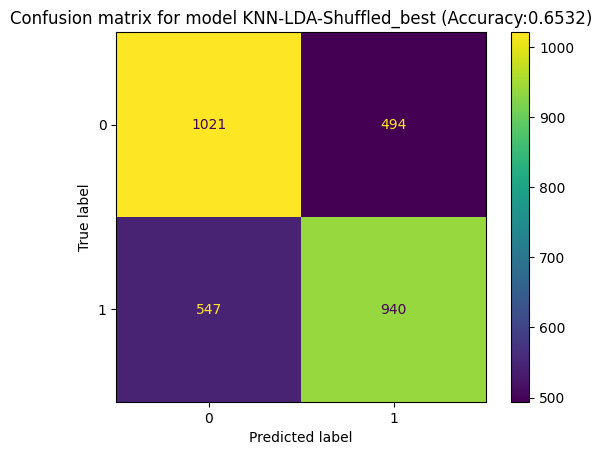

,Accuracy,Weighted F1,Weighted Precision,Weighted Recall,Macro-Averaged Precision,Macro-Averaged Recall,F1,Precision
KNN-LDA-Shuffled_best,0.653231,0.653066,0.653308,0.653231,0.653329,0.653036,[0.66234187 0.6436152 ],[0.65114796 0.65550907]


In [30]:
calculate_metrics('KNN-LDA-Shuffled_best', y_best_predictions, best_predictions)